#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, LogNormalAFTFitter

In [2]:
df = pd.read_csv("telco.csv")
print(df.shape)
df.head(3)

(1000, 15)


,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No


#### Feature Engineering

In [3]:
df["churn"] = df["churn"].map({"Yes": 1, "No": 0}) # Map churn to binary
df = df.drop(columns=["ID"]) # Drop ID column since it should not be used for prediction

# One-hot encode categorical variables (except churn)
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "churn"]

X = pd.get_dummies(
    df.drop(columns=["tenure", "churn"]), # Since this is what we are trying to predict
    columns=cat_cols,
    drop_first=True
)

# Adding duration and event columns required by lifelines
X["tenure"] = df["tenure"]
X["churn"]  = df["churn"]

X.head()

,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,tenure,churn
0,44,9,64,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,13,1
1,33,7,136,False,True,False,False,False,True,False,False,True,True,False,True,False,False,True,11,1
2,52,24,116,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,68,0
3,33,12,33,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,33,1
4,30,9,30,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,23,0


#### Build AFT models with all the available distributions

According to the lifelines documentation  
<https://lifelines.readthedocs.io/en/latest/lifelines.fitters.html>,  
the available **AFT (Accelerated Failure Time) regression models** are:

- **WeibullAFTFitter**  
- **LogLogisticAFTFitter**  
- **LogNormalAFTFitter**

These correspond to the three parametric AFT distributions supported in lifelines.

In [4]:
aft_classes = {
    "WeibullAFT": WeibullAFTFitter,
    "LogLogisticAFT": LogLogisticAFTFitter,
    "LogNormalAFT": LogNormalAFTFitter,
}

fitted = {}
rows = []

for name, cls in aft_classes.items():
    model = cls()
    model.fit(X, duration_col="tenure", event_col="churn")
    fitted[name] = model

    ll = model.log_likelihood_
    k = model.params_.size
    n = len(X)
    aic = -2 * ll + 2 * k
    bic = -2 * ll + k * np.log(n)

    rows.append({
        "model": name,
        "log_likelihood": ll,
        "num_params": k,
        "AIC": aic,
        "BIC": bic,
    })

results = pd.DataFrame(rows).sort_values("AIC")
results

,model,log_likelihood,num_params,AIC,BIC
2,LogNormalAFT,-1457.012005,20,2954.024010,3052.179116
1,LogLogisticAFT,-1458.104281,20,2956.208561,3054.363667
0,WeibullAFT,-1462.171624,20,2964.343248,3062.498354


**We can see from the results that the Log-Normal AFT model has the highest log-likelihood and lowest AIC/BIC, so it provides the best overall fit.**

#### Visualization

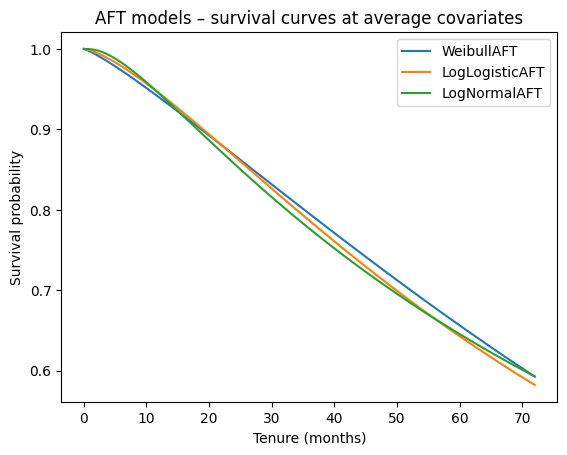

In [5]:
avg_row = X.drop(columns=["tenure", "churn"]).mean().to_frame().T
t_grid = np.linspace(0, X["tenure"].max(), 100)

plt.figure()
for name, model in fitted.items():
    sf = model.predict_survival_function(avg_row, times=t_grid)
    plt.plot(t_grid, sf.values.flatten(), label=name)

plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.title("AFT models – survival curves at average covariates")
plt.legend()
plt.show()


- the Weibull curve starts of lower than the rest (from 0 to 10) but eventually lies slightly above the others (predicts a bit higher survival / lower churn risk)
- the Log-Normal curve starts of higher(from 0 to 10), then through months 30-55 lies slightly below the others(predicts more churn), but in the end, at month 70, it predicts same survival proability of around 0.6 as Weibull
- the Log-Logistic curve sits in between these two most of the time, and starting from 55th month, it predicts the lowest survival proability between those 3 (a bit lower than 0.6)

#### Which model would I use as a decision maker (thinking about other factors apart from the above comparisons)

I would choose the Log-Normal AFT model because, apart the fact that it has the best statistical fit (lowest AIC and BIC) that we see above, it allows a non-monotonic hazard (risk can increase for newer customers and then stabilize/decline for loyal ones)

#### Keeping the best model and significant features

In [6]:
best_name = results.loc[results["AIC"].idxmin(), "model"]
best_model = fitted[best_name]

print("Best AFT model by AIC:", best_name)

Best AFT model by AIC: LogNormalAFT


##### I choose alpha=0.05

In [7]:
alpha = 0.05
summary = best_model.summary
p_col = "p" if "p" in summary.columns else "p-value"
sig_rows = summary[summary[p_col] < alpha].copy()

print("Significant features:")
sig_rows

Significant features:


coef  exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                              
mu_    address                0.042538   1.043456  0.008904        0.025088   
       age                    0.032670   1.033209  0.007254        0.018452   
       custcat_E-service      1.066401   2.904907  0.170532        0.732165   
       custcat_Plus service   0.924929   2.521689  0.215751        0.502065   
       custcat_Total service  1.198617   3.315528  0.250452        0.707741   
       internet_Yes          -0.771490   0.462324  0.143483       -1.052710   
       marital_Unmarried     -0.455134   0.634363  0.115430       -0.681372   
       voice_Yes             -0.433787   0.648050  0.168953       -0.764929   
       Intercept              2.362263  10.614950  0.292629        1.788721   
sigma_ Intercept              0.275772   1.317548  0.045998        0.185617   

                              coef upper 95%  exp(coef) lower 95%  \
param  covariate                                                    
mu_    address                      0.059989             1.025405   
       age                          0.046887             1.018624   
       custcat_E-service            1.400637             2.079579   
       custcat_Plus service         1.347793             1.652129   
       custcat_Total service        1.689493             2.029401   
       internet_Yes                -0.490269             0.348991   
       marital_Unmarried           -0.228896             0.505922   
       voice_Yes                   -0.102646             0.465367   
       Intercept                    2.935805             5.981799   
sigma_ Intercept                    0.365928             1.203961   

                              exp(coef) upper 95%  cmp to         z  \
param  covariate                                                      
mu_    address                           1.061825     0.0  4.777676   
       age                               1.048004     0.0  4.503760   
       custcat_E-service                 4.057784     0.0  6.253394   
       custcat_Plus service              3.848923     0.0  4.287021   
       custcat_Total service             5.416735     0.0  4.785820   
       internet_Yes                      0.612462     0.0 -5.376880   
       marital_Unmarried                 0.795411     0.0 -3.942958   
       voice_Yes                         0.902447     0.0 -2.567503   
       Intercept                        18.836666     0.0  8.072559   
sigma_ Intercept                         1.441851     0.0  5.995251   

                                         p   -log2(p)  
param  covariate                                       
mu_    address                1.773326e-06  19.105111  
       age                    6.676160e-06  17.192550  
       custcat_E-service      4.016273e-10  31.213423  
       custcat_Plus service   1.810853e-05  15.752971  
       custcat_Total service  1.702906e-06  19.163569  
       internet_Yes           7.578744e-08  23.653466  
       marital_Unmarried      8.048267e-05  13.600962  
       voice_Yes              1.024338e-02   6.609164  
       Intercept              6.883999e-16  50.367603  
sigma_ Intercept              2.031709e-09  28.874659

In [8]:
print("\nNon-significant features:")
summary[summary[p_col] >= alpha]


Non-significant features:


coef  exp(coef)  se(coef)  \
param covariate                                                        
mu_   ed_Did not complete high school  0.373624   1.452990  0.201587   
      ed_High school degree            0.315938   1.371546  0.163183   
      ed_Post-undergraduate degree    -0.034399   0.966186  0.223172   
      ed_Some college                  0.272306   1.312989  0.165346   
      forward_Yes                     -0.198139   0.820256  0.180037   
      gender_Male                      0.051869   1.053238  0.114287   
      income                           0.001396   1.001397  0.000920   
      region_Zone 2                   -0.097068   0.907494  0.142769   
      region_Zone 3                    0.048258   1.049441  0.141538   
      retire_Yes                       0.022532   1.022788  0.444076   

                                       coef lower 95%  coef upper 95%  \
param covariate                                                         
mu_   ed_Did not complete high school       -0.021480        0.768727   
      ed_High school degree                 -0.003894        0.635771   
      ed_Post-undergraduate degree          -0.471808        0.403009   
      ed_Some college                       -0.051766        0.596379   
      forward_Yes                           -0.551005        0.154728   
      gender_Male                           -0.172130        0.275868   
      income                                -0.000408        0.003200   
      region_Zone 2                         -0.376891        0.182755   
      region_Zone 3                         -0.229152        0.325667   
      retire_Yes                            -0.847842        0.892906   

                                       exp(coef) lower 95%  \
param covariate                                              
mu_   ed_Did not complete high school             0.978749   
      ed_High school degree                       0.996113   
      ed_Post-undergraduate degree                0.623873   
      ed_Some college                             0.949551   
      forward_Yes                                 0.576370   
      gender_Male                                 0.841870   
      income                                      0.999592   
      region_Zone 2                               0.685991   
      region_Zone 3                               0.795208   
      retire_Yes                                  0.428338   

                                       exp(coef) upper 95%  cmp to         z  \
param covariate                                                                
mu_   ed_Did not complete high school             2.157019     0.0  1.853409   
      ed_High school degree                       1.888478     0.0  1.936099   
      ed_Post-undergraduate degree                1.496321     0.0 -0.154139   
      ed_Some college                             1.815533     0.0  1.646885   
      forward_Yes                                 1.167340     0.0 -1.100543   
      gender_Male                                 1.317674     0.0  0.453847   
      income                                      1.003205     0.0  1.517008   
      region_Zone 2                               1.200520     0.0 -0.679895   
      region_Zone 3                               1.384954     0.0  0.340953   
      retire_Yes                                  2.442217     0.0  0.050739   

                                              p  -log2(p)  
param covariate                                            
mu_   ed_Did not complete high school  0.063824  3.969763  
      ed_High school degree            0.052856  4.241800  
      ed_Post-undergraduate degree     0.877500  0.188528  
      ed_Some college                  0.099582  3.327976  
      forward_Yes                      0.271096  1.883126  
      gender_Male                      0.649939  0.621624  
      income                           0.129265  2.951600  
      region_Zone 2                    0.496571  1.0099

In [9]:
if isinstance(sig_rows.index, pd.MultiIndex):
    covariates = sig_rows.index.get_level_values(-1)
else:
    covariates = sig_rows.index
sig_covs = sorted(set(covariates) - {"Intercept"})
print("Significant covariates:", sig_covs)

Significant covariates: ['address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'internet_Yes', 'marital_Unmarried', 'voice_Yes']


#### Refitting final model using only significant features

In [10]:
X_sig = X[sig_covs + ["tenure", "churn"]]

FinalModelClass = type(best_model)
final_model = FinalModelClass()
final_model.fit(X_sig, duration_col="tenure", event_col="churn")

print("Final model (refit on significant features only):", FinalModelClass.__name__)
final_model.summary


Final model (refit on significant features only): LogNormalAFTFitter


coef  exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                              
mu_    address                0.042824   1.043754  0.008847        0.025483   
       age                    0.036826   1.037512  0.006400        0.024283   
       custcat_E-service      1.025825   2.789395  0.169047        0.694499   
       custcat_Plus service   0.822553   2.276303  0.169425        0.490485   
       custcat_Total service  1.013269   2.754590  0.209579        0.602501   
       internet_Yes          -0.840528   0.431483  0.138259       -1.111511   
       marital_Unmarried     -0.447317   0.639341  0.114472       -0.671679   
       voice_Yes             -0.463493   0.629082  0.166771       -0.790359   
       Intercept              2.534887  12.615010  0.242611        2.059379   
sigma_ Intercept              0.283034   1.327150  0.046020        0.192836   

                              coef upper 95%  exp(coef) lower 95%  \
param  covariate                                                    
mu_    address                      0.060164             1.025811   
       age                          0.049369             1.024580   
       custcat_E-service            1.357150             2.002706   
       custcat_Plus service         1.154620             1.633109   
       custcat_Total service        1.424036             1.826682   
       internet_Yes                -0.569545             0.329061   
       marital_Unmarried           -0.222956             0.510850   
       voice_Yes                   -0.136628             0.453682   
       Intercept                    3.010396             7.841100   
sigma_ Intercept                    0.373231             1.212684   

                              exp(coef) upper 95%  cmp to          z  \
param  covariate                                                       
mu_    address                           1.062011     0.0   4.840293   
       age                               1.050608     0.0   5.754395   
       custcat_E-service                 3.885105     0.0   6.068295   
       custcat_Plus service              3.172818     0.0   4.854960   
       custcat_Total service             4.153852     0.0   4.834781   
       internet_Yes                      0.565783     0.0  -6.079365   
       marital_Unmarried                 0.800150     0.0  -3.907654   
       voice_Yes                         0.872294     0.0  -2.779221   
       Intercept                        20.295430     0.0  10.448373   
sigma_ Intercept                         1.452420     0.0   6.150258   

                                         p   -log2(p)  
param  covariate                                       
mu_    address                1.296478e-06  19.556971  
       age                    8.695261e-09  26.777123  
       custcat_E-service      1.292752e-09  29.526907  
       custcat_Plus service   1.204113e-06  19.663598  
       custcat_Total service  1.332924e-06  19.516974  
       internet_Yes           1.206593e-09  29.626414  
       marital_Unmarried      9.319665e-05  13.389362  
       voice_Yes              5.448947e-03   7.519807  
       Intercept              1.490611e-25  82.472298  
sigma_ Intercept              7.735690e-10  30.267751

#### CLV per customer based on the final AFT model using the significant features

In [11]:
T = 36 # horizon: 36 months
r = 0.12 # annual discount rate

times = np.arange(1, T + 1)
discount_factors = (1 + r/12) ** (times - 1)

X_cov_sig = X_sig.drop(columns=["tenure", "churn"])
surv_matrix = final_model.predict_survival_function(
    X_cov_sig,
    times=times
).values

clv_unit = (surv_matrix / discount_factors[:, None]).sum(axis=0)
segment_cols = set()

for cov in sig_covs:
    if cov in df.columns:
        segment_cols.add(cov)
    else:
        base = cov.split("_")[0]
        if base in df.columns:
            segment_cols.add(base)

segment_cols = sorted(segment_cols)
df_clv = df[segment_cols].copy()
df_clv["CLV_unit_margin_36m"] = clv_unit
print("Categorical segment columns from significant features:", segment_cols)
df_clv.head()


Categorical segment columns from significant features: ['address', 'age', 'custcat', 'internet', 'marital', 'voice']


,address,age,custcat,internet,marital,voice,CLV_unit_margin_36m
0,9,44,Basic service,No,Married,No,27.254662
1,7,33,Total service,No,Married,Yes,27.470196
2,24,52,Plus service,No,Married,No,30.211892
3,12,33,Basic service,No,Unmarried,No,23.712566
4,9,30,Plus service,No,Married,No,28.260736


#### Exploring CLV with different segments

In [12]:
# Categorical columns
cat_segment_cols = ["custcat", "internet", "marital", "voice"]

for col in cat_segment_cols:
    print(f"\nAverage unit-margin CLV by {col}:")
    s = (
        df_clv
        .groupby(col)["CLV_unit_margin_36m"]
        .mean()
        .sort_index()
        .round(2)
    )
    print(s.to_string())


Average unit-margin CLV by custcat:
custcat
Basic service    23.14
E-service        27.30
Plus service     28.15
Total service    24.90

Average unit-margin CLV by internet:
internet
No     27.31
Yes    23.38

Average unit-margin CLV by marital:
marital
Married      26.88
Unmarried    24.87

Average unit-margin CLV by voice:
voice
No     26.43
Yes    24.57


- **Average unit-margin CLV by custcat**

We see that CLV is highest for Plus service and E-service customers, and lowest for Basic service, so higher-tier plans create more long-term value.

- **Average unit-margin CLV by internet**

We see that customers without internet have higher CLV than those with internet, suggesting internet users churn earlier and may need targeted retention.

- **Average unit-margin CLV by marital**

We see that unmarried customers have lower CLV, suggeesting they churn earlier and need some more attention to try to keep them

- **Average unit-margin CLV by voice**

We see that people who have voice churn earlier, suggesting voice subscribers need more attention to try to keep them

In [13]:
df["address"].unique()

array([ 9,  7, 24, 12, 17,  2,  5, 21, 10, 14,  8, 30,  3, 38, 19, 18,  0,
       11,  1,  6, 27, 26, 13, 34,  4, 20, 28, 36, 16, 15, 22, 44, 29, 23,
       31, 25, 49, 41, 39, 43, 33, 32, 35, 40, 37, 45, 48, 42, 46, 55])

In [14]:
# Numeric-derived (binned) columns
num_segment_cols = ["age_group", "address_group"]

df_clv["age"] = df_clv["age"]        # already there, but harmless
df_clv["address"] = df_clv["address"]

age_bins = [0, 30, 40, 50, 100]
age_labels = ["<30", "30–39", "40–49", "50+"]
df_clv["age_group"] = pd.cut(df_clv["age"],
                             bins=age_bins,
                             labels=age_labels,
                             right=False)

addr_bins = [0, 5, 10, 20, 100]
addr_labels = ["<5", "5–9", "10–19", "20+"]
df_clv["address_group"] = pd.cut(df_clv["address"],
                                 bins=addr_bins,
                                 labels=addr_labels,
                                 right=False)

for col in num_segment_cols:
    print(f"\nAverage unit-margin CLV by {col}:")
    s = (
        df_clv
        .groupby(col, observed=False)["CLV_unit_margin_36m"]
        .mean()
        .sort_index()
        .round(2)
    )
    print(s.to_string())



Average unit-margin CLV by age_group:
age_group
<30      21.17
30–39    24.57
40–49    27.05
50+      29.24

Average unit-margin CLV by address_group:
address_group
<5       22.73
5–9      24.99
10–19    27.33
20+      29.67


- **Average unit-margin CLV by age group**

We see that CLV increases with age, from about 21.2 for <30 to about 29.2 for 50+, so older customers create more long-term value

- **Average unit-margin CLV by address tenure group**

We see that CLV increases with time at the same address, from about 22.7 for <5 to about 29.7 for 20+, so more settled customers create more long-term value

#### Computing number of at-risk subscribers within a year

In [15]:
times_12 = np.array([12])
s12 = final_model.predict_survival_function(X_cov_sig, times=times_12).values[0]

df_clv["S_12m"] = s12
df_clv["churn_prob_12m"] = 1 - df_clv["S_12m"]

threshold = 0.20
at_risk_mask = df_clv["churn_prob_12m"] > threshold

n_at_risk = int(at_risk_mask.sum())
pct_at_risk = 100 * n_at_risk / len(df_clv)

avg_clv_at_risk = df_clv.loc[at_risk_mask, "CLV_unit_margin_36m"].mean()
total_clv_at_risk = df_clv.loc[at_risk_mask, "CLV_unit_margin_36m"].sum()

# Expected number of churners in the next 12 months (sum of probabilities)
expected_churners_12m = df_clv["churn_prob_12m"].sum()

print(f"At-risk subscribers (12m, p(churn) > {threshold:.0%}): {n_at_risk} "
      f"({pct_at_risk:.1f}% of sample)")
print(f"Average unit-margin CLV of at-risk group: {avg_clv_at_risk:.2f}")
print(f"Total unit-margin CLV at risk: {total_clv_at_risk:.2f}")
print(f"Expected number of churners in 12 months: {expected_churners_12m:.1f}")

At-risk subscribers (12m, p(churn) > 20%): 200 (20.0% of sample)
Average unit-margin CLV of at-risk group: 19.06
Total unit-margin CLV at risk: 3812.94
Expected number of churners in 12 months: 110.6


#### Annual Retention Budget (e.g. if we are willing to spend 20-30%)

In [16]:
alpha_min, alpha_max = 0.20, 0.30

budget_min = alpha_min * total_clv_at_risk
budget_max = alpha_max * total_clv_at_risk

print(
    f"Annual retention budget range (α in [{alpha_min:.2f}, {alpha_max:.2f}]): "
    f"[{budget_min:.2f}, {budget_max:.2f}] in unit-margin terms"
)


Annual retention budget range (α in [0.20, 0.30]): [762.59, 1143.88] in unit-margin terms


# Report

#### The final Log-Normal AFT model shows that plan type and services are the main drivers of churn. Higher-tier plans (Plus, E-service) are associated with much longer expected tenure and higher CLV, while having internet and voice services and being unmarried all shorten expected lifetime. Age and address tenure also matter, so older and more settled customers are more valuable. I define “valuable” segments as those with both high CLV and low 12-month churn probability; under this definition, Plus and E-service customers without internet (and typically older, married, and stable at one address) are the most valuable, whereas Basic customers who use internet and voice and are unmarried form the at-risk group.

#### Using the predicted survival at 12 months and defining “at-risk” as having more than 20% chance of churn within a year, I identify 200 at-risk subscribers, i.e. 20% of the sample. Their average unit-margin CLV is about 19 and the total CLV at risk is around 3,813, implying an expected 12-month churn of roughly 111 customers. If we are willing to spend 20–30% of this at-risk CLV on retention, the annual retention budget would be in the range of about 760–1,140. I would focus this budget on high-CLV but at-risk segments: especially internet/voice users on lower plans, younger customers, and those who recently moved. I would create targeted discounts or bundles, onboarding and service-quality improvements, and then evaluate these interventions with A/B tests using the same survival/CLV framework.

#### Note: CLV is computed over a 36-month horizon with a 12% annual discount, in unit-margin terms